# Safety levels

NEN 8700 specifies a number of safety levels, which are essentially reliability indices that a construction must meet:

| Safety level | Assessment level |
|--------------|------------------|
| CC3          | 3.3              |
| CC2          | 2.5              |
| CC1b         | 1.8              |
| CC1a         | 1.8              |


In this example, we will show how to apply the safety levels to assess the bearing capacity of a pile. 

### Define model

First, let's import the necessary classes:

In [172]:
from probabilistic_library import UncertaintyProject, DistributionType, UncertaintyMethod, StandardNormal

We use the Koppejan method to calculate the bearing capacity of a pile ($p$).

For this example, we assume there are two soil layers: the top layer is clay, and the bottom layer is sand. The surface level is at $0$ m+NAP. The soil has the following characteristics:

| Parameter | Description                          |
|-----------|--------------------------------------|
| z         | Depth at which the sand layer starts |
| q_clay    | CPT resistance in clay layer         |
| q_sand    | CPT resistance in sand layer         |
    
The pile has the following characteristics:

| Parameter | Description         |
|-----------|---------------------|
| D         | Diameter of the pile|
| L         | Length of the pile  |

The Koppejan method is implemented in the following function:

In [173]:
from utils.models import get_bearing_capacity

The bearing capacity of a pile is compared with the applied load, resulting in a unity check value (UC). A UC value greater than $1.0$ indicates failure, meaning the load exceeds the bearing capacity of the pile.

In [174]:
def get_unity_check(load, z, q_clay, q_sand, D, L):
    p = get_bearing_capacity(z, q_clay, q_sand, D, L)
    uc = load / p

    return uc

### Uncertainty analysis

The goal is to calculate the UC values at the safety levels. To achieve this, we conduct a uncertainty analysis. We begin by creating a uncertainty project and defining the model:

In [175]:
project = UncertaintyProject()
project.model = get_unity_check

project.model.print()

Model get_unity_check:
Input parameters:
  load
  z
  q_clay
  q_sand
  D
  L
Output parameters:
  uc


### Assign variables

The following values and uncertainties are applied to the variables. The load is derived from a design value and is recalculated as a stochastic variable, as we want to perform a full probabilistic calculation.

In [176]:
project.variables["D"].distribution = DistributionType.normal
project.variables["D"].mean = 0.2
project.variables["D"].deviation = 0.04
project.variables["D"].truncated = True
project.variables["D"].minimum = 0.0
project.variables["D"].maximum = 1.0

project.variables["L"].distribution = DistributionType.normal
project.variables["L"].mean = 12.0
project.variables["L"].deviation = 0.8

project.variables["z"].distribution = DistributionType.normal
project.variables["z"].mean = 10.0
project.variables["z"].deviation = 0.2

project.variables["q_sand"].distribution = DistributionType.log_normal
project.variables["q_sand"].mean = 500.0
project.variables["q_sand"].deviation = 50.0

project.variables["q_clay"].distribution = DistributionType.log_normal
project.variables["q_clay"].mean = 25000.0
project.variables["q_clay"].deviation = 400.0

project.variables["load"].distribution = DistributionType.gumbel
project.variables["load"].design_quantile = 0.95
project.variables["load"].design_factor = 1.0
project.variables["load"].variation = 0.1
project.variables["load"].design_value = 100000.0

print("Load = {0} +- {1}".format(project.variables["load"].mean, project.variables["load"].deviation))

Load = 84275.78591160773 +- 8427.578591160775


### Perform calculation 

We perform the uncertainty analysis using `crude_monte_carlo` method:

In [177]:
project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
project.settings.maximum_samples = 10000
project.run()
uc_mc = project.stochast

Next, we derive the values of UC, which correspond to the predefined safety levels. If the UC value for a given safety level is greater than $1.0$, then that safety level is not met.

In [178]:
safety_levels = [1.8, 2.5, 3.3]
safety_levels_txt = ["CC1b", "CC2 ", "CC3 "]
uc_sl = []

def check_sl(uc, safety_levels, safety_levels_txt):

    for idx, sl in enumerate(safety_levels):
        p = StandardNormal.get_p_from_u(sl)
        uc_sl.append(uc.get_quantile(p))
        print (f"Safety level ({safety_levels_txt[idx]}):  {sl} => UC = {uc_sl[-1]}")

    return uc_sl

uc_sl = check_sl(uc_mc, safety_levels, safety_levels_txt)

Safety level (CC1b):  1.8 => UC = 0.8564457238247961
Safety level (CC2 ):  2.5 => UC = 1.0979807121952414
Safety level (CC3 ):  3.3 => UC = 1.6925889446516011


Let's plot the results:

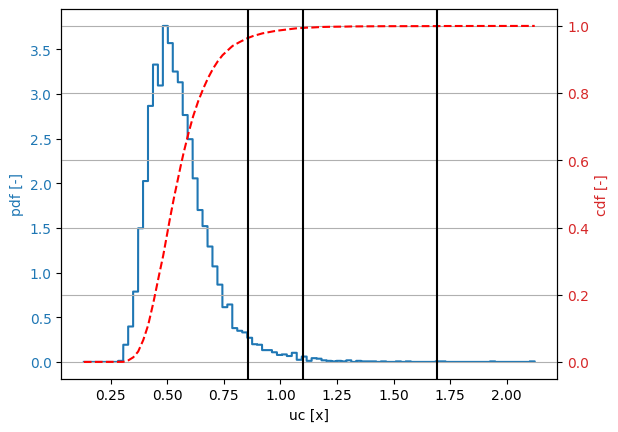

In [179]:
plt = uc_mc.get_plot()
for val in uc_sl:
    plt.grid()
    plt.axvline(x=val, color='black', linestyle='-')


We see that the pile construction meets only the safety level CC1b. Safety levels CC2 and CC3 are not met.

### Alternative methods

We can also apply other uncertainty methods: `form`, `importance_sampling` or `directional_sampling`. 

For `directional_sampling`, it is neceessary to predefine the quantiles in which we are interested (the reliability index $3.3$ is not calculated well, therefore another value is used).

In [180]:
safety_levels_ds = [1.8, 2.5, 3.0]

project.settings.uncertainty_method = UncertaintyMethod.directional_sampling
project.settings.maximum_directions = 1000
project.settings.variation_coefficient = 0.01
for sl in safety_levels_ds:
    project.settings.quantiles.append(StandardNormal.get_p_from_u(sl))

project.run()
project.result.print()

Variable uc:
  distribution = cdf_curve
Definition:
  beta[0.8537] = 1.8
  beta[1.086] = 2.5
  beta[1.299] = 3
Derived values:
  mean = 0.2568
  deviation = 0.3322
  variation = 1.294
Quantiles:
  quantile 0.9641: [8.766e+04, 9.874, 2.488e+04, 483.5, 0.1325, 11.85] -> [0.8537] -> 0.8537
  quantile 0.9938: [8.971e+04, 9.827, 2.483e+04, 478.3, 0.1073, 11.8] -> [1.086] -> 1.086
  quantile 0.9987: [9.109e+04, 9.798, 2.48e+04, 475.1, 0.0915, 11.77] -> [1.299] -> 1.299


Let's plot the results:

Safety level (CC1b):  1.8 => UC = 0.8537128868245834
Safety level (CC2 ):  2.5 => UC = 1.0859117555680067
Safety level (CC3 ):  3.0 => UC = 1.2989508870840587


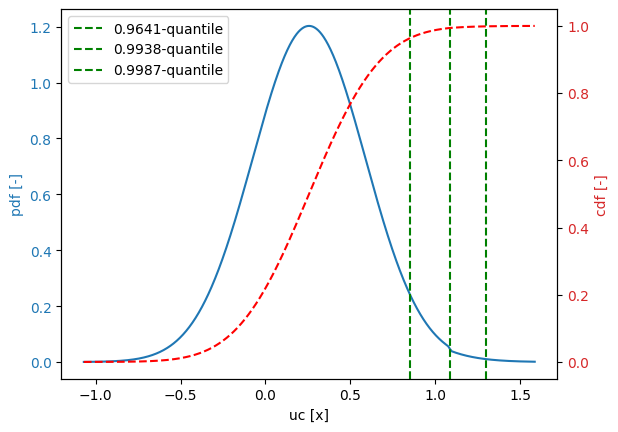

In [ ]:
check_sl(project.result.variable, safety_levels_ds, safety_levels_txt)
project.result.plot()
